In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("assignment7.ipynb")

# Applied Neural Networks using PyTorch

This assignment aims to give you practical experience in building, training, and evaluating neural networks using PyTorch. You'll apply neural networks to a real-world dataset and gain hands-on experience with industry-standard tools and techniques.

[PyTorch](https://pytorch.org/) is an open-source machine learning library developed by Facebook's AI Research lab. It provides a flexible and efficient platform for building and training neural networks. It supports all kinds of applications: computer vision, natural language processing, and reinforcement learning. PyTorch is an extremely popular choice for both research and production environments.

## Part 1 

## Data Preparation

In [2]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

We'll be using the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). It consists of 60,000 32x32 color images divided into 100 different classes, with 600 images per class. The dataset is split into 50,000 training images and 10,000 test images. The 100 classes are grouped into 20 superclasses. For example, the superclass "fish" contains classes like "aquarium fish", "flatfish", "ray", "shark", and "trout". This makes CIFAR-100 more challenging than similar datasets like CIFAR-10, as it requires models to make more fine-grained distinctions between classes.

PyTorch has a library called `torchvision` that provides a comprehensive set of tools for working with images and videos. We can load CIFAR-100 (and others!) using `torchvision.datasets`. 

We're also defining some transformations that will be performed on the images when loading the dataset. 

**Question 1:** Your first task two-fold: 

1. Define the `training_set` and `validation_set` variables to the appropriate splits of the CIFAR-100 dataset. Don't forget to apply the transforms. Use [this documentation page](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR100.html) for reference.
2. Define the `training_loader` and `validation_loader` varibles to dataloaders for the two datasets we instantiated before. Provide a batch size of 64.

In [3]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Note that this will download the dataset into a directory called 'data' in your current working directory
training_set = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
validation_set = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# To simplify the data loading, we will use a DataLoader object provided by PyTorch with a batch size of 64
training_loader = DataLoader(training_set, batch_size=64, shuffle=True)

validation_loader = DataLoader(validation_set, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
grader.check("q1")

q1 results: All test cases passed!

### Data Exploration

In [5]:
print(f"Training set has {len(training_set)} images")
print(f"Validation set has {len(validation_set)} images")

Training set has 50000 images
Validation set has 10000 images


In [6]:
print(f"Each image is of size {training_set[0][0].size()}")

Each image is of size torch.Size([3, 32, 32])


You can view the classes using `.classes`. 

In [7]:
classes = training_set.classes
print(f"Classes: {classes}")
print(f"Number of classes: {len(classes)}")

Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'will

Remember, the `training_loader` is defined as an iterable that returns images in
batches. We can see how many iterations are required to return unique batches of
our training dataset.

In [8]:
print(f"Training loader has {len(training_loader)} batches")

Training loader has 782 batches


Let's look at some of the images.  You can re-run this cell to look at a different batch.

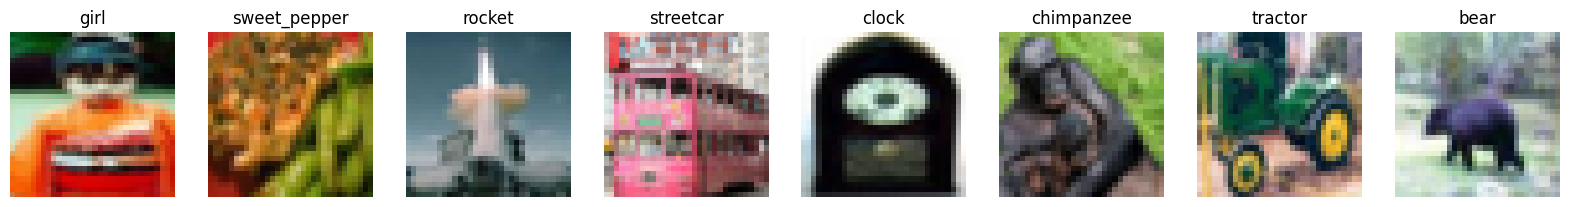

In [9]:
images, labels = next(iter(training_loader)) # This loads a batch of images and their labels

# Display the images
fig, axs = plt.subplots(1, 8, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(classes[labels[i]])
    ax.axis('off')
    
plt.show()

We can also look at the histograms of each channel of the batch of images as well
as compute the mean and standard deviation.

Mean: tensor([0.5065, 0.4810, 0.4470])
Std: tensor([0.2698, 0.2533, 0.2780])


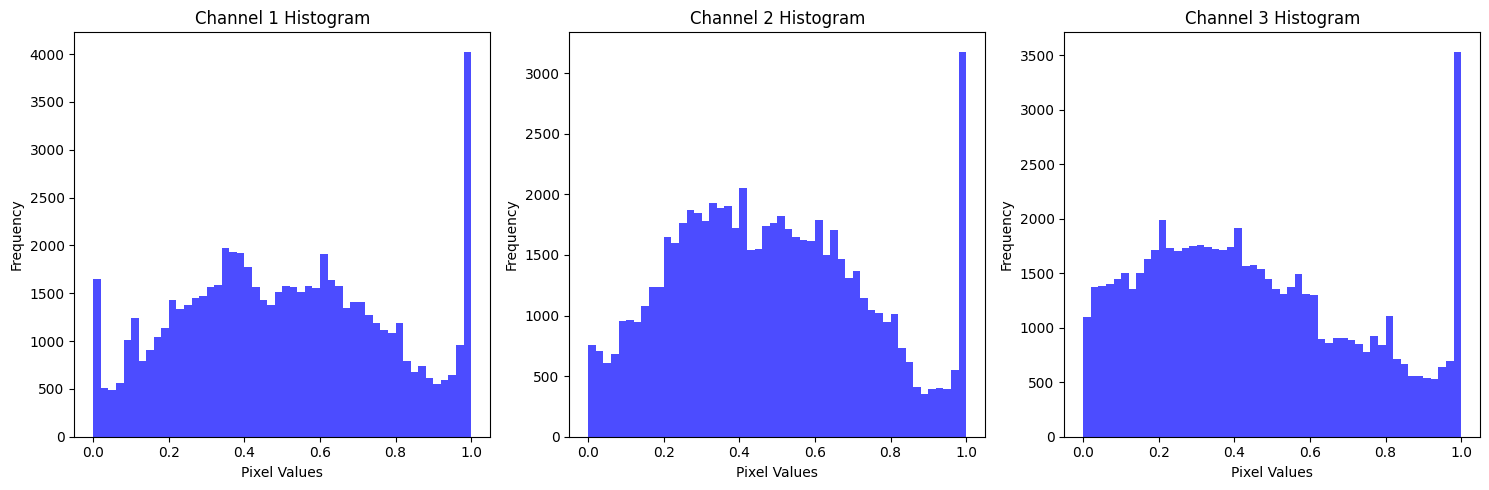

In [10]:
import matplotlib.pyplot as plt

images, labels = next(iter(training_loader))

# Assuming `images` is a batch of images with shape (batch_size, channels, height, width)
batch_size, channels, height, width = images.shape

# Compute mean and std for each channel
mean = images.mean(dim=[0, 2, 3])
std = images.std(dim=[0, 2, 3])

print(f"Mean: {mean}")
print(f"Std: {std}")

# Plot histograms for each channel
fig, axs = plt.subplots(1, channels, figsize=(15, 5))
for i in range(channels):
    axs[i].hist(images[:, i, :, :].flatten().numpy(), bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'Channel {i+1} Histogram')
    axs[i].set_xlabel('Pixel Values')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Part 2 

## Building and Training a Convolutional Neural Network

In this part, we will build a Convolutional Neural Network (CNN) from scratch to classify the images in our dataset. CNNs are particularly well-suited for image classification tasks because they can automatically learn hierarchical features from the input images through their convolutional layers.
# 
We will:
1. Define a CNN architecture with convolutional layers, pooling layers, and fully connected layers
2. Train the model using our training data
3. Evaluate the model's performance on the test set

The CNN will need to learn to distinguish between our 100 different classes of images by identifying relevant features and patterns in the input data.


**Question 2:** Define a class called `CNN` which we will use to instantiate our model. Use the `torch.nn` module to define it's layers and the `torch.nn.functional` library to define activations. Your model should have at least one convolutional layer. You are free to define the rest of the layers model and activations - for example, you could have a series of convolutional layers followed by a series of linear layers. We encourage you to experiment and get your prediction accuracy as high as possible! 

Use [the course notes on CNNs](https://tools4ds.github.io/DS701-Course-Notes/25-NN-III-CNNs.html#define-a-cnn-in-pytorch), [the discussion notebook on neural networks](https://github.com/tools4ds/ds701_fa2024_assignments/blob/main/discussions/discussion11/discussion11-NN.ipynb) and PyTorch documentation for reference. 

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 100)
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.log_softmax(x, dim = 1)
        
        return x

# Create an instance of the CNN
model = CNN()
print(model)


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=100, bias=True)
)


In [12]:
grader.check("q2")

q2 results: All test cases passed!

**Question 3**: Define the optimizer and the loss function. Pick what's appropriate from PyTorch documentation. 

In [13]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [14]:
grader.check("q3")

q3 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 4:** Train the model for at least 10 epochs, and plot the performance. Define a function `train_model` that takes the training and validation dataloaders, optimizer, loss function, and the number of epochs to train.

The function should return the training losses and validation accuracies. 

The training loop is as follows:

```

For each epoch:
   Set model to training mode
   Send model to device (GPU) using .to(device)
   For each batch in training dataloader:
     Get inputs and labels from batch. Send inputs to GPU device. 

     Zero out gradients
     Forward pass through model
     Calculate loss
     Backward pass
     Update weights
   
   Set model to evaluation mode - remember, no backprop/gradient calculation!
   For each batch in validation dataloader:
     Get inputs and labels from batch
     Forward pass through model
     Calculate validation loss
   
   Store training and validation metrics. Print them if you'd like. 

```


In [15]:
# FOR FASTER TRAINING, USE GPU IF AVAILABLE
device = torch.device('cuda' if torch.cuda.is_available(
) else 'mps' if torch.backends.mps.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cpu


/home/huanghy/miniconda3/envs/ds701_env/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [18]:
from tqdm import tqdm

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

model.to(device)

# Training loop
def train_model(model, training_loader, validation_loader, optimizer, loss_fn, device, EPOCHS):
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)

    # Training loop
    for epoch in tqdm(range(EPOCHS), desc="Epochs"):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training phase
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
                        
            outputs = model(inputs)  # Forward pass

            # YOUR CODE HERE
            optimizer.zero_grad()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate accuracy
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(training_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # YOUR CODE HERE
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                
                #_, predicted = torch.max(outputs.data, 1)
                predicted = torch.argmax(outputs, 1)
                # print(f"predicted: {predicted}")
                # print(f"labels: {labels}")
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(validation_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{EPOCHS}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
EPOCHS = 2 # was 10

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, 
                                                                         training_loader, 
                                                                         validation_loader, 
                                                                         optimizer, 
                                                                         loss_fn, 
                                                                         device, 
                                                                         EPOCHS)

Epochs:  10%|█         | 1/10 [01:01<09:13, 61.46s/it]

Epoch [1/10]
Train Loss: 4.5882, Train Acc: 1.93%
Val Loss: 4.5397, Val Acc: 3.85%
------------------------------------------------------------


Epochs:  20%|██        | 2/10 [02:05<08:23, 62.92s/it]

Epoch [2/10]
Train Loss: 4.2667, Train Acc: 5.93%
Val Loss: 4.0334, Val Acc: 9.20%
------------------------------------------------------------


Epochs:  30%|███       | 3/10 [03:09<07:25, 63.60s/it]

Epoch [3/10]
Train Loss: 3.8963, Train Acc: 11.01%
Val Loss: 3.8019, Val Acc: 13.28%
------------------------------------------------------------


Epochs:  40%|████      | 4/10 [04:13<06:22, 63.78s/it]

Epoch [4/10]
Train Loss: 3.7262, Train Acc: 14.05%
Val Loss: 3.6953, Val Acc: 15.15%
------------------------------------------------------------


Epochs:  50%|█████     | 5/10 [05:17<05:17, 63.59s/it]

Epoch [5/10]
Train Loss: 3.5992, Train Acc: 16.34%
Val Loss: 3.6031, Val Acc: 16.41%
------------------------------------------------------------


Epochs:  60%|██████    | 6/10 [06:20<04:14, 63.59s/it]

Epoch [6/10]
Train Loss: 3.4937, Train Acc: 18.06%
Val Loss: 3.5070, Val Acc: 18.63%
------------------------------------------------------------


Epochs:  70%|███████   | 7/10 [07:26<03:13, 64.47s/it]

Epoch [7/10]
Train Loss: 3.3990, Train Acc: 19.84%
Val Loss: 3.4305, Val Acc: 19.07%
------------------------------------------------------------


Epochs:  80%|████████  | 8/10 [08:29<02:07, 63.91s/it]

Epoch [8/10]
Train Loss: 3.3038, Train Acc: 21.42%
Val Loss: 3.3358, Val Acc: 21.05%
------------------------------------------------------------


Epochs:  90%|█████████ | 9/10 [09:34<01:04, 64.29s/it]

Epoch [9/10]
Train Loss: 3.2130, Train Acc: 23.02%
Val Loss: 3.2652, Val Acc: 22.77%
------------------------------------------------------------


Epochs: 100%|██████████| 10/10 [10:38<00:00, 63.80s/it]

Epoch [10/10]
Train Loss: 3.1202, Train Acc: 24.77%
Val Loss: 3.1988, Val Acc: 23.94%
------------------------------------------------------------


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 5**: Plotting model performance. 

Create two plots: 
- Training loss against epochs
- Validation accuracy epochs

Make sure your plots are appropriately labeled. 

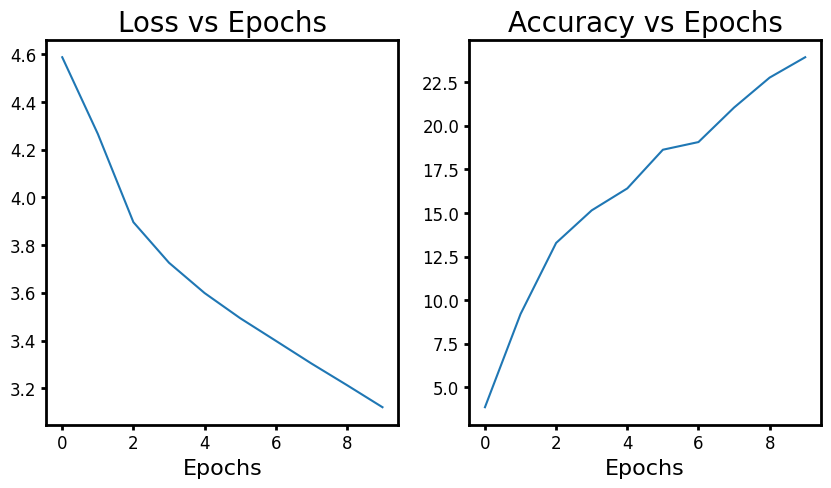

In [23]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True)

fig.set_size_inches(10, 5)
ax1.spines[['top', 'bottom', 'left', 'right']].set_linewidth(2)
ax1.tick_params(width=2, labelsize=12)
ax2.spines[['top', 'bottom', 'left', 'right']].set_linewidth(2)
ax2.tick_params(width=2, labelsize=12)

ax1.plot(train_losses)
ax1.set_title('Loss vs Epochs', fontsize=20)
ax1.set_xlabel('Epochs', fontsize=16)
#ax1,set_ylabel('Loss', fontsize=16)
ax2.plot(val_accuracies)
ax2.set_title('Accuracy vs Epochs', fontsize=20)
ax2.set_xlabel('Epochs', fontsize=16)
#ax2.set_ylabel('Accuracy', fontsize=16)
plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Compare the loss and accuracy plots for training versus validation. What do you notice?

(Replace this text with your answer.)

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)